## Imports

In [1]:
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset
from seqeval.metrics import f1_score
from collections import Counter, defaultdict
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoConfig, DataCollatorForTokenClassification 
from transformers import TrainingArguments, Trainer
from datasets import load_dataset, Dataset, load_metric, DatasetDict
from collections import Counter, defaultdict
import seaborn as sns
from matplotlib import pyplot as plt

/home/eli/envs/bt/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model

In [2]:
model_name = 'xlm-roberta-base'

## Tokenizer

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_name) # more params defined in method tokenize_and_align_labels()

## Data collator

In [4]:
data_collator = DataCollatorForTokenClassification(tokenizer)

## Training params

In [5]:
NUM_EPOCHS = 10
BATCH_SIZE = 2
LOGGING_STRATEGY='epoch'
OUTPUT_DIR = f'{model_name}-finetuned-smartdata_{NUM_EPOCHS}_epochs'
OVERWRITE_OUTPUT_DIR = True # only for first experiments
LOG_LEVEL = 'error'
EVALUATION_STRATEGY = 'epoch'
SAVE_STRATEGY ='epoch'
WEIGHT_DECAY = 0.01 # The weight decay to apply (if not zero) to all layers except all bias and LayerNorm weights in AdamW optimizer.

## Check GPU and set up torch device

In [6]:
# check gpu
torch.cuda.is_available()

True

In [7]:
# create torch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load dataset

In [8]:
df = pd.read_json('../../../NER/prepare_data/telegram_dataset/data_prepared/ds_telegram.json')

In [9]:
print(f"Dataset contains {len(df)} rows with columns {df.columns.values}.")

Dataset contains 500 rows with columns ['id' 'tokens' 'ner_tags'].


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        500 non-null    object
 1   tokens    500 non-null    object
 2   ner_tags  500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [11]:
# df = df.dropna() # only needed in case of null values

In [12]:
df.head()

id  \
0   Demotermine125028861058202021-02-02 12:42:26   
1   Demotermine125028861034202020-10-27 21:36:50   
2  Demotermine1250288610304832021-12-07 07:05:19   
3   Demotermine125028861040852020-11-22 09:54:32   
4  Demotermine1250288610131262021-07-28 21:41:05   

                                              tokens  \
0  [💚, Bitte, kommt, wieder, zahlreich, nach, Poi...   
1  [Ludwigsburg, 01112020, @querdenken7141, @EfAu...   
2  [Lichtermeer, am, 06.12.2021, vorm, Rathaus, i...   
3  [https://demo.terminkalender.top, /, Aktualisi...   
4  [Bodo, Schiffmann, Interview, mit, ARD, (, Kob...   

                                            ner_tags  
0  [O, O, O, O, O, O, B-LOC, O, B-ACTION, O, O, B...  
1                        [B-LOC, B-DATE, O, O, O, O]  
2  [B-ACTION, O, B-DATE, O, B-LOC, O, B-LOC, O, B...  
3                  [O, O, O, O, O, O, O, O, O, O, O]  
4  [B-PER, I-PER, O, O, B-ORG, O, B-LOC, O, B-DAT...

## Methods

In [13]:
def show_example(split='train', idx=0):
    example = ds[split][idx]
    return pd.DataFrame([example['tokens'], example['ner_tags_str']], ['tokens', 'tags'])

def get_entity_freqs(ds):
    split2freqs = defaultdict(Counter)

    for split, dataset in ds.items():
        for row in dataset['ner_tags_str']:
            for tag in row: 
                if tag.startswith('B'):
                    tag_type = tag.split('-')[1]
                    split2freqs[split][tag_type] += 1
    return pd.DataFrame.from_dict(split2freqs, orient='index')

In [14]:
def get_indices_and_tags():
    
    tags = ['O', 
            'B-DATE', 'I-DATE', 
            'B-LOC', 'I-LOC', 
            'B-ORG', 'I-ORG',
            'B-PER', 'I-PER',
            'B-TIME', 'I-TIME',
            'B-ACTION',
            'I-ACTION']
    
    index2tag = {idx: tag for idx, tag in enumerate(tags)}
    tag2index = {tag: idx for idx, tag in enumerate(tags)}    
    
    #print(f"tags: {tags}\n\nindex2tag: {index2tag}\n\ntag2index: {tag2index}")
    return tags, index2tag, tag2index


def ner_tags_str2id(ner_tags_str):
    
    tag_ids = []

    for tag in ner_tags_str:         
        idx = tag2index[tag]
        tag_ids.append(int(idx))
        
    return tag_ids


def tokenize_and_align_labels(examples):
    
    tokenized_inputs = tokenizer(
        examples['tokens'], 
        padding='max_length',
        truncation=True, 
        is_split_into_words=True
    )    
    
    labels = []
    
    for idx, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else: 
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs['labels'] = labels
    return tokenized_inputs


def encode_dataset(corpus, columns_to_remove=['ner_tags', 'tokens', 'ner_tags_str', '__index_level_0__']):
    return corpus.map(tokenize_and_align_labels, 
                      batched=True,
                      remove_columns=columns_to_remove)

In [15]:
# Evaluation

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
        labels_list.append(example_labels)
        preds_list.append(example_preds)
        
    return preds_list, labels_list    


def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    return {'f1': f1_score(y_true, y_pred)}


def get_training_history(trainer):
    df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1']]
    df = df.rename(columns={"epoch":"Epoch","loss": "Training Loss", "eval_loss": "Validation Loss", "eval_f1":"F1"})
    df['Epoch'] = df["Epoch"].apply(lambda x: round(x))
    df['Training Loss'] = df["Training Loss"].ffill()
    df[['Validation Loss', 'F1']] = df[['Validation Loss', 'F1']].bfill().ffill()
    df.drop_duplicates()
    
    return df

In [16]:
tags, index2tag, tag2index = get_indices_and_tags()

In [17]:
type(tag2index)

dict

## Create dataset from dataframe

In [18]:
df.head()

id  \
0   Demotermine125028861058202021-02-02 12:42:26   
1   Demotermine125028861034202020-10-27 21:36:50   
2  Demotermine1250288610304832021-12-07 07:05:19   
3   Demotermine125028861040852020-11-22 09:54:32   
4  Demotermine1250288610131262021-07-28 21:41:05   

                                              tokens  \
0  [💚, Bitte, kommt, wieder, zahlreich, nach, Poi...   
1  [Ludwigsburg, 01112020, @querdenken7141, @EfAu...   
2  [Lichtermeer, am, 06.12.2021, vorm, Rathaus, i...   
3  [https://demo.terminkalender.top, /, Aktualisi...   
4  [Bodo, Schiffmann, Interview, mit, ARD, (, Kob...   

                                            ner_tags  
0  [O, O, O, O, O, O, B-LOC, O, B-ACTION, O, O, B...  
1                        [B-LOC, B-DATE, O, O, O, O]  
2  [B-ACTION, O, B-DATE, O, B-LOC, O, B-LOC, O, B...  
3                  [O, O, O, O, O, O, O, O, O, O, O]  
4  [B-PER, I-PER, O, O, B-ORG, O, B-LOC, O, B-DAT...

In [19]:
df = df.rename(columns={'ner_tags': 'ner_tags_str'})
df['ner_tags'] = df.ner_tags_str.apply(lambda x: ner_tags_str2id(x))

In [20]:
np.random.seed(0)
msk = np.random.rand(len(df)) < 0.9
train = df[["ner_tags", "ner_tags_str", "tokens"]][msk]
test = df[["ner_tags", "ner_tags_str", "tokens"]][~msk]

In [21]:
train_ds = Dataset.from_pandas(train[["tokens", "ner_tags", "ner_tags_str"]])
test_ds = Dataset.from_pandas(test[["tokens", "ner_tags", "ner_tags_str"]])

In [22]:
ds = DatasetDict({"train": train_ds, "test": test_ds})
ds

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'ner_tags_str', '__index_level_0__'],
        num_rows: 443
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'ner_tags_str', '__index_level_0__'],
        num_rows: 57
    })
})

In [23]:
show_example(idx=2)

0   1           2     3        4   5        6  7   \
tokens  Lichtermeer  am  06.12.2021  vorm  Rathaus  in  Dresden  —   
tags       B-ACTION   O      B-DATE     O    B-LOC   O    B-LOC  O   

                8      9   ...    13   14   15       16             17 18  \
tokens  QUERDENKEN    351  ...  Raus  auf  die  Straßen  @Demotermine!  👉   
tags         B-ORG  I-ORG  ...     O    O    O        O              O  O   

               19 20        21 22  
tokens  Übersicht  /  Overview  👈  
tags            O  O         O  O  

[2 rows x 23 columns]

In [24]:
get_entity_freqs(ds)

LOC  ACTION  DATE  TIME  ORG  PER
train  1136     279   384   195  153  101
test    143      26    39    21   23    9

In [25]:
ds_encoded = encode_dataset(ds)

Parameter 'function'=<function tokenize_and_align_labels at 0x7f923f838940> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 53.65ba/s]


## model initialization and config

In [26]:
model_config = AutoConfig.from_pretrained(model_name, 
                                        num_labels=len(tags), 
                                        id2label=index2tag,
                                        label2id=tag2index)

In [27]:
model = AutoModelForTokenClassification.from_pretrained(model_name, config=model_config)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-st

## Training

In [28]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR, 
    overwrite_output_dir=OVERWRITE_OUTPUT_DIR, 
    log_level=LOG_LEVEL, 
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE, 
    evaluation_strategy=EVALUATION_STRATEGY,
    save_strategy=SAVE_STRATEGY,
    weight_decay=WEIGHT_DECAY,
    logging_strategy=LOGGING_STRATEGY,
    disable_tqdm=False)

In [29]:
trainer = Trainer(
    model=model, 
    args=training_args,
    data_collator=data_collator, 
    compute_metrics=compute_metrics,
    train_dataset=ds_encoded['train'],
    eval_dataset=ds_encoded['test'],
    tokenizer=tokenizer)

In [30]:
trainer.train()

/home/eli/envs/bt/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RuntimeError: CUDA error: CUBLAS_STATUS_NOT_INITIALIZED when calling `cublasCreate(handle)`

In [46]:
trainer.evaluate()

{'eval_loss': 0.31602486968040466,
 'eval_f1': 0.7535641547861507,
 'eval_runtime': 0.8404,
 'eval_samples_per_second': 67.825,
 'eval_steps_per_second': 34.507,
 'epoch': 10.0}

In [48]:
eval_df = get_training_history(trainer)

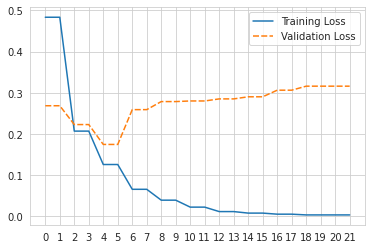

In [50]:
sns.set_style("whitegrid")
ax = sns.lineplot(data = eval_df[['Training Loss', 'Validation Loss']])
ax.set_xticks(range(len(eval_df)), labels=range(len(eval_df)))
plt.show()